# This is my header


And this is a really cool thing

In [6]:
from IPython.display import display, HTML

import re
import io
import pandas as pd
from pandas.util.testing import assert_frame_equal

class TableData:
    def __init__(self, table):
        self.df = self.as_df(table)

    def as_df(self, table):
        # Remove trailing comments
        table_to_parse = re.compile(r'(#.*$)', flags = re.MULTILINE).sub('', table)
        
        # Remove beginning and terminal pipe on each row
        table_to_parse = re.compile(r'(^\s*\|\s*|\s*\|\s*$)', flags = re.MULTILINE).sub('', table_to_parse)
        
        # Remove whitespace surrouding pipes
        table_to_parse = re.compile(r'\s*\|\s*').sub('|', table_to_parse)
        
        # Remove header separator
        table_to_parse = table_to_parse.split('\n')
        table_to_parse.pop(1)
        table_to_parse = '\n'.join(table_to_parse)

        parsed_df = pd.read_csv(io.StringIO(table_to_parse), sep="|")
        return TableData.stringify_df(parsed_df)

    @classmethod
    def stringify_df(cls, df):
        for col in df.columns:
            df[col] = df[col].apply(lambda x: str(x))
        return df

    @classmethod
    def compare_stringified_df(cls, df1, df2):
        df1 = cls.stringify_df(df1.copy())
        df2 = cls.stringify_df(df2.copy())
        return df1.equals(df2)


TableData(
    '''
    | alpha | beta |
    | -     | -    |
    | one   | two  |
    '''
).df

,alpha,beta
0,one,two


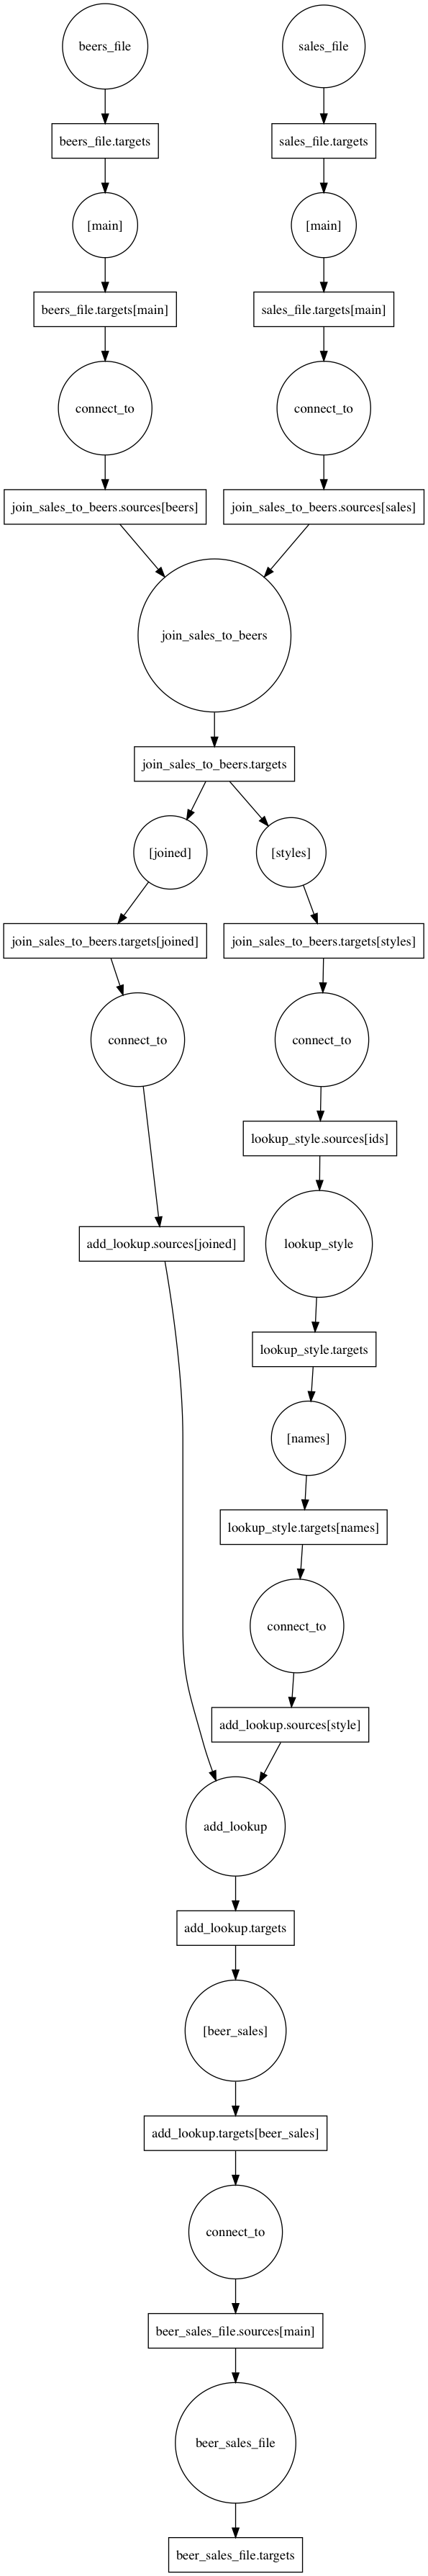

In [7]:
import importlib
import jobs
import jobs.simple_job
importlib.reload(jobs.simple_job)
importlib.reload(pemi.pipes.generic)
importlib.reload(pemi.pipes.dask)

import pemi
import pandas as pd

import logging
pemi.log().setLevel(logging.DEBUG)

beers_csv = TableData(
    '''
    | id | name            | style_id | abv | price |
    | -  | -               | -        | -   | -     |
    | 1  | Spin Cycle      | 1        | 7.2 | 4.99  |
    | 2  | Old Style       | 2        | 4.2 | 3.99  |
    | 3  | Pipewrench      | 1        | 8.3 | 10.99 |
    | 4  | Abst Red Ribbon | 7        | 3.2 | 1.99  |
    '''
).df

sales_csv = TableData(
    '''
    | beer_id | sold_at    | quantity |
    | -       | -          | -        |
    | 1       | 2017-01-01 | 3        |
    | 1       | 2017-01-04 | 2        |
    | 2       | 2017-01-06 | 7        |
    | 4       | 2017-01-06 | 8        |
    | 3       | 2017-01-14 | 1        |
    | 3       | 2017-01-15 | 3        |
    | 2       | 2017-01-16 | 3        |
    | 1       | 2017-01-16 | 4        |
    | 4       | 2017-01-17 | 5        |
    | 1       | 2017-01-20 | 2        |
    | 3       | 2017-01-20 | 1        |
    '''
).df

job = jobs.simple_job.MyJob()

class MockLocalCsvFileSourcePipe(pemi.pipes.csv.LocalCsvFileSourcePipe):
    def flow(self):
        pass

class MockLocalCsvFileTargetPipe(pemi.pipes.csv.LocalCsvFileTargetPipe):
    def flow(self):
        pass

# HOW ABOUT A MOCK METHOD THAT RETURNS A CLASS LIKE THIS

mock_beers_file_pipe = MockLocalCsvFileSourcePipe(
    schema=job.pipes['beers_file'].schema,
    paths=job.pipes['beers_file'].paths,
)

mock_beers_file_pipe.targets['main'].data = beers_csv

job.pipe(
    name='beers_file',
    pipe=mock_beers_file_pipe
)

mock_sales_file_pipe = MockLocalCsvFileSourcePipe(
    schema=job.pipes['sales_file'].schema,
    paths=job.pipes['sales_file'].paths,
)

mock_sales_file_pipe.targets['main'].data = sales_csv

job.pipe(
    name='sales_file',
    pipe=mock_sales_file_pipe
)

mock_beer_sales_file_pipe = MockLocalCsvFileTargetPipe(
    schema=job.pipes['beer_sales_file'].schema,
    path=job.pipes['beer_sales_file'].path
)

job.pipe(
    name='beer_sales_file',
    pipe=mock_beer_sales_file_pipe
)

for conn in job.connections:
    mock_pipes = ['beers_file', 'sales_file', 'beer_sales_file']
    if conn.from_pipe.name in mock_pipes:
        conn.from_pipe = job.pipes[conn.from_pipe.name]
    if conn.to_pipe.name in mock_pipes:
        conn.to_pipe = job.pipes[conn.to_pipe.name]
        

job.dask.graph()
#job.pipes['sales_file'].targets['main'].data
# job.flow()
# job.pipes['beer_sales_file'].sources['main'].data


INFO:pemi:DaskPipe flowing pipe <DummyPipe(a)>
INFO:pemi:My name is a and I am doing really cool stuff!
DEBUG:pemi:Getting target q from pipe <DummyPipe(a)>
DEBUG:pemi:connecting <DataTarget(q)> to <DataSource(a)>
INFO:pemi:DaskPipe flowing pipe <DummyPipe(b)>
INFO:pemi:My name is b and I am doing really cool stuff!
DEBUG:pemi:Getting target q from pipe <DummyPipe(b)>
DEBUG:pemi:connecting <DataTarget(q)> to <DataSource(b)>
INFO:pemi:DaskPipe flowing pipe <DummyPipe(q)>
INFO:pemi:My name is q and I am doing really cool stuff!
DEBUG:pemi:Getting target x from pipe <DummyPipe(q)>
DEBUG:pemi:connecting <DataTarget(x)> to <DataSource(q)>
INFO:pemi:DaskPipe flowing pipe <DummyPipe(x)>
INFO:pemi:My name is x and I am doing really cool stuff!
DEBUG:pemi:Getting target y from pipe <DummyPipe(q)>
DEBUG:pemi:connecting <DataTarget(y)> to <DataSource(q)>
INFO:pemi:DaskPipe flowing pipe <DummyPipe(y)>
INFO:pemi:My name is y and I am doing really cool stuff!


My name is a and I am doing really cool stuff!
My name is b and I am doing really cool stuff!
My name is q and I am doing really cool stuff!
My name is x and I am doing really cool stuff!
My name is y and I am doing really cool stuff!


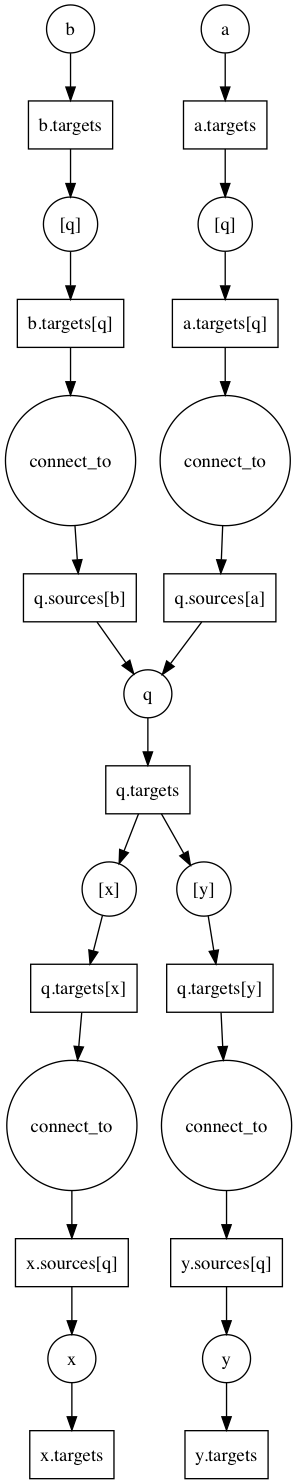

In [3]:
import pemi
#import pemi.pipes
import pemi.pipes.dask


import importlib
importlib.reload(pemi.pipes.dask)

import logging
logging.basicConfig()
logging.getLogger('pemi').setLevel(logging.DEBUG)


class DummyPipe(pemi.Pipe):
    def config(self):
        
        if 'sources' in self.params:
            for source in self.params['sources']:
                self.source(name=source)

        if 'targets' in self.params:
            for target in self.params['targets']:
                self.target(name=target)
            
    def flow(self):
        pemi.log().info('My name is {} and I am doing really cool stuff!'.format(self.name))
        print('My name is {} and I am doing really cool stuff!'.format(self.name))
'''
a -> q
b -> q
q -> x
q -> y
'''

class MyJob(pemi.Pipe):
    def config(self):
        self.pipe(name='a', pipe=DummyPipe(targets=['q']))
        self.pipe(name='b', pipe=DummyPipe(targets=['q']))
        self.pipe(name='q', pipe=DummyPipe(sources=['a','b'], targets=['x','y']))
        self.pipe(name='x', pipe=DummyPipe(sources=['q']))
        self.pipe(name='y', pipe=DummyPipe(sources=['q']))
        
        self.connect(self.pipes['a'], 'q').to(self.pipes['q'], 'a')
        self.connect(self.pipes['b'], 'q').to(self.pipes['q'], 'b')
        self.connect(self.pipes['q'], 'x').to(self.pipes['x'], 'q')
        self.connect(self.pipes['q'], 'y').to(self.pipes['y'], 'q')
        
        self.dask = pemi.pipes.dask.DaskFlow(self.connections)
        
    def flow(self):
        self.dask.flow()


job = MyJob()
job.flow()
job.dask.graph()


In [26]:
# REAL DATA!


import importlib
import jobs
import jobs.simple_job
importlib.reload(jobs.simple_job)
importlib.reload(pemi.pipes.generic)
importlib.reload(pemi.pipes.dask)
importlib.reload(pemi.pipes.csv)

import pemi
import pandas as pd

import logging
pemi.log().setLevel(logging.DEBUG)

job = jobs.simple_job.MyJob()


#job.dask.graph()
job.flow()
print('beers_file')
display(job.pipes['beers_file'].targets['main'].data)
print('sales_file')
display(job.pipes['sales_file'].targets['main'].data)
print('sales_file errors')
display(job.pipes['sales_file'].targets['error'].data)
if len(job.pipes['sales_file'].targets['error'].data) > 0:
    print(list(job.pipes['sales_file'].targets['error'].data['__mapping_errors__']))
print('beer_sales_file')
display(job.pipes['beer_sales_file'].sources['main'].data)


INFO:pemi:DaskPipe flowing pipe <LocalCsvFileSourcePipe(beers_file)>
DEBUG:pemi:Getting target main from pipe <LocalCsvFileSourcePipe(beers_file)>
DEBUG:pemi:connecting <DataTarget(main)> to <DataSource(beers)>
INFO:pemi:DaskPipe flowing pipe <LocalCsvFileSourcePipe(sales_file)>
DEBUG:pemi:Getting target main from pipe <LocalCsvFileSourcePipe(sales_file)>
DEBUG:pemi:connecting <DataTarget(main)> to <DataSource(sales)>
INFO:pemi:DaskPipe flowing pipe <JoinSalesToBeersPipe(join_sales_to_beers)>
DEBUG:pemi:Getting target styles from pipe <JoinSalesToBeersPipe(join_sales_to_beers)>
DEBUG:pemi:connecting <DataTarget(styles)> to <DataSource(ids)>
INFO:pemi:DaskPipe flowing pipe <LookupStylePipe(lookup_style)>
DEBUG:pemi:Getting target names from pipe <LookupStylePipe(lookup_style)>
DEBUG:pemi:connecting <DataTarget(names)> to <DataSource(style)>
DEBUG:pemi:Getting target joined from pipe <JoinSalesToBeersPipe(join_sales_to_beers)>
DEBUG:pemi:connecting <DataTarget(joined)> to <DataSource(joi

df is    beer_id     sold_at quantity id           name style_id  abv  price  \
0        1  2017-01-01        3  1      SpinCycle        1  7.2   4.99   
1        1  2017-01-04        2  1      SpinCycle        1  7.2   4.99   
2        1  2017-01-16        4  1      SpinCycle        1  7.2   4.99   
3        1  2017-01-20        2  1      SpinCycle        1  7.2   4.99   
4        2  2017-01-06        7  2       OldStyle        2  4.2   3.99   
5        2  2017-01-16        3  2       OldStyle        2  4.2   3.99   
6        4  2017-01-06        8  4  AbstRedRibbon        7  3.2   1.99   
7        4  2017-01-17        5  4  AbstRedRibbon        7  3.2   1.99   
8        3  2017-01-14        1  3     Pipewrench        1  8.3  10.99   
9        3  2017-01-15        3  3     Pipewrench        1  8.3  10.99   
10       3  2017-01-20        1  3     Pipewrench        1  8.3  10.99   

           style  
0            IPA  
1            IPA  
2            IPA  
3            IPA  
4         

,id,name,style_id,abv,price
0,1,SpinCycle,1,7.2,4.99
1,2,OldStyle,2,4.2,3.99
2,3,Pipewrench,1,8.3,10.99
3,4,AbstRedRibbon,7,3.2,1.99


sales_file


,beer_id,sold_at,quantity
0,1,2017-01-01,3
1,1,2017-01-04,2
2,2,2017-01-06,7
3,4,2017-01-06,8
4,3,2017-01-14,1
5,3,2017-01-15,3
6,2,2017-01-16,3
7,1,2017-01-16,4
8,4,2017-01-17,5
9,1,2017-01-20,2


sales_file errors


""


beer_sales_file


,beer_id,sold_at,quantity,id,name,style_id,abv,price,style
0,1,2017-01-01,3,1,SpinCycle,1,7.2,4.99,IPA
1,1,2017-01-04,2,1,SpinCycle,1,7.2,4.99,IPA
2,1,2017-01-16,4,1,SpinCycle,1,7.2,4.99,IPA
3,1,2017-01-20,2,1,SpinCycle,1,7.2,4.99,IPA
4,2,2017-01-06,7,2,OldStyle,2,4.2,3.99,Pale
5,2,2017-01-16,3,2,OldStyle,2,4.2,3.99,Pale
6,4,2017-01-06,8,4,AbstRedRibbon,7,3.2,1.99,Unknown id 7
7,4,2017-01-17,5,4,AbstRedRibbon,7,3.2,1.99,Unknown id 7
8,3,2017-01-14,1,3,Pipewrench,1,8.3,10.99,IPA
9,3,2017-01-15,3,3,Pipewrench,1,8.3,10.99,IPA


In [4]:
import pemi

ds = pemi.DataSubject(
    schema = {
        'beer_id':  {'type': 'integer', 'required': True},
        'sold_at':  {'type': 'date', 'in_format': '%m/%d/%Y', 'required': True},
        'quantity': {'type': 'integer', 'required': True}
    }
)

tabular = '''
    | beer_id | sold_at    | quantity |
    | -       | -          | -        |
    | 1       | 2017-01-01 | 3        |
    | 1       | 2017-01-04 | 2        |
    | 2       | 2017-01-06 | 7        |
'''

# Want to mock with real data, supplemented with FAKER data

